In [1]:
# conda activate aso_design
import pandas as pd
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
import numpy as np
from asodesigner.util import get_antisense
import pickle
from read_human_genome import get_locus_to_data_dict
from file_utils import read_human_genome_fasta_dict
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
csv_path = os.path.join(project_root, 'scripts', 'data_genertion', 'data_asoptimizer_updated.csv')
all_data = pd.read_csv(csv_path)

/tmp/ipykernel_228239/3258365118.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(csv_path)


In [2]:
# Column name definitions from the ASO experiment dataset.
SEQUENCE = 'Sequence'
INHIBITION = 'Inhibition(%)'
CANONICAL_GENE = 'Canonical Gene Name'
CELL_LINE_ORGANISM = 'Cell line organism'
VOLUME = 'ASO_volume(nM)'
TREATMENT_PERIOD = 'Treatment_Period(hours)'
CELL_LINE = 'Cell_line'
TRANSFECTION = 'Transfection'
DENSITY = 'Density(cells/well)'
MODIFICATION = 'Modification'

Preprocessing ASO Experimental Dataset

In [3]:
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [4]:
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [5]:
# Load gene information from cache or generate it if needed
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)


In [6]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [7]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,41212.0,0.901972,16,0,A431,-4.204708,TAGCATTTGTTTTAGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41212,16
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,23686.0,0.518395,16,0,A431,-4.532610,GATATTCACCATTATA,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23686,16
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,43363.0,0.949049,16,1,A431,-3.637612,CCAGAAATCTTCATGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",43363,16
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,23680.0,0.518264,16,0,A431,-4.276680,TTTGAAGATATTCACC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23680,16
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,41168.0,0.901009,16,0,A431,-4.158899,CATACTAGTACAAGTG,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41168,16


Adding Flanked Sense Sequences to Dataset

In [8]:
def get_sense_with_flanks(pre_mrna: str, sense_start: int, sense_length: int, flank_size: int) -> str:
    """
    Re  turns the sense sequence with `flank_size` nucleotides on each side (if available).
    If near the edge, it will not go out of bounds.

    Parameters:
    - pre_mrna: The full pre-mRNA sequence (5' -> 3')
    - sense_start: Start index of the sense sequence within pre_mrna
    - sense_length: Length of the sense sequence (usually same as antisense length)
    - flank_size: Number of nucleotides to include on each side (upstream and downstream)

    Returns:
    - str: The flanked sense sequence
    """
    # Ensure indices are within bounds
    start = max(0, sense_start - flank_size)
    end = min(len(pre_mrna), sense_start + sense_length + flank_size)

    return pre_mrna[start:end]


In [9]:
FLANK_SIZE = 120  # Change this as needed
FLANKED_SENSE_COL = f'sense_with_flank_{FLANK_SIZE}nt'

# Create new column with flanked sequences
all_data_human_gene[FLANKED_SENSE_COL] = all_data_human_gene.apply(
    lambda row: get_sense_with_flanks(
        row['pre_mrna_sequence'],
        row['sense_start'],
        row['sense_length'],
        flank_size=FLANK_SIZE
    ) if row['sense_start'] != -1 else "",  # Handle cases where sense was not found
    axis=1
)


In [10]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length,sense_with_flank_120nt
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,0.901972,16,0,A431,-4.204708,TAGCATTTGTTTTAGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41212,16,"(A, T, G, G, T, A, A, A, A, A, G, A, A, G, A, ..."
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,0.518395,16,0,A431,-4.532610,GATATTCACCATTATA,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23686,16,"(C, T, C, T, T, G, G, A, T, A, T, T, C, T, C, ..."
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,0.949049,16,1,A431,-3.637612,CCAGAAATCTTCATGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",43363,16,"(T, A, G, A, C, A, G, A, A, C, C, C, T, A, T, ..."
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,0.518264,16,0,A431,-4.276680,TTTGAAGATATTCACC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23680,16,"(A, C, C, T, G, T, C, T, C, T, T, G, G, A, T, ..."
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,0.901009,16,0,A431,-4.158899,CATACTAGTACAAGTG,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41168,16,"(A, T, T, A, G, T, T, C, G, A, G, A, A, A, T, ..."


Running RNAaccess on the sense with flanks

In [11]:
from yehuda_code.access_calculator import AccessCalculator
def compute_sense_accessibility(row, flank_size, access_win_size, seed_sizes, access_size, min_gc=0, max_gc=100, gc_ranges=1):
    try:
        # Skip invalid rows
        if row['sense_start'] == -1 or pd.isna(row['sense_with_flank_120nt']) or row['sense_with_flank_120nt'] == "":
            return None

        seq = row[f'sense_with_flank_{flank_size}nt']
        sense_start = row['sense_start']
        sense_length = row['sense_length']

        # Calculate accessibility
        df_access = AccessCalculator.calc(
            seq, access_size,
            min_gc, max_gc, gc_ranges,
            access_win_size, seed_sizes
        )

        flank_start = max(0, sense_start - flank_size)
        sense_start_in_flank = sense_start - flank_start
        sense_end_in_flank = sense_start_in_flank + sense_length

        if 0 <= sense_start_in_flank < len(df_access) and sense_end_in_flank <= len(df_access):
            values = df_access['avg_access'].iloc[sense_start_in_flank:sense_end_in_flank].dropna()
            return values.mean() if not values.empty else None
        else:
            return None

    except Exception as e:
        print(f"Error at row {row.name} | seq start: {row['sense_start']} | error: {e}")
        return None


In [12]:
def compute_batch_accessibility(df, flank_size, access_win_size, seed_sizes, access_size,
                                min_gc=0, max_gc=100, gc_ranges=1):
    # list of the results
    results = []

    for i, row in df.iterrows():
        try:
            if row['sense_start'] == -1 or pd.isna(row[f'sense_with_flank_{flank_size}nt']) or row[f'sense_with_flank_{flank_size}nt'] == "":
                results.append(None)
                continue

            seq = row[f'sense_with_flank_{flank_size}nt']
            sense_start = row['sense_start']
            sense_length = row['sense_length']

            # access calculation for each sense
            df_access = AccessCalculator.calc(
                seq, access_size,
                min_gc, max_gc, gc_ranges,
                access_win_size, seed_sizes
            )

            flank_start = max(0, sense_start - flank_size)
            sense_start_in_flank = sense_start - flank_start
            sense_end_in_flank = sense_start_in_flank + sense_length

            if 0 <= sense_start_in_flank < len(df_access) and sense_end_in_flank <= len(df_access):
                values = df_access['avg_access'].iloc[sense_start_in_flank:sense_end_in_flank].dropna()
                results.append(values.mean() if not values.empty else None)
            else:
                results.append(None)

        except Exception as e:
            print(f"Error at row {i}: {e}")
            results.append(None)

    return results


### Final best parameters


Parameters that were tested:

- **Access window sizes:**
  `[10, 15, 20, 25, 35, 45, 60, 70, 80, 100]`

- **Seed sizes:**
  `[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]`

- **Accessibility sizes (ACCESS_SIZES):**
  `[13, 14, 15, 16, 17, 18, 19]`

Using the best access_win_size = 70, checking the seed size 13


In [13]:
FLANK_SIZE = 120
ACCESS_SIZE = 13
SEED_SIZE = 13
SEED_SIZES = [SEED_SIZE * m for m in range(1, 4)]
ACCESS_WIN_SIZE = 80

In [14]:
import os
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
import pandas as pd
# Create a unique output folder name with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = f"partial_batches_{timestamp}"
os.makedirs(output_folder, exist_ok=True)
print(f"Output will be saved to: {output_folder}")


Output will be saved to: partial_batches_20250716_231921


In [24]:
batch_size = 500
for start_idx in range(0, len(all_data_human_gene), batch_size):
    end_idx = min(start_idx + batch_size, len(all_data_human_gene))
    batch = all_data_human_gene.iloc[start_idx:end_idx].copy()

    print(f"Processing rows {start_idx} to {end_idx}...")

    batch['sense_avg_accessibility'] = batch.apply(
        compute_sense_accessibility,
        axis=1,
        flank_size=FLANK_SIZE,
        access_win_size=ACCESS_WIN_SIZE,
        seed_sizes=SEED_SIZES,
        access_size=ACCESS_SIZE,
    )

    # Save batch to the new folder
    batch.to_csv(f"{output_folder}/batch_{start_idx}_{end_idx}.csv", index=False)


Processing rows 0 to 500...
Processing rows 500 to 1000...
Processing rows 1000 to 1500...
Processing rows 1500 to 2000...
Processing rows 2000 to 2500...
Processing rows 2500 to 3000...
Processing rows 3000 to 3500...
Processing rows 3500 to 4000...
Processing rows 4000 to 4500...
Processing rows 4500 to 5000...
Processing rows 5000 to 5500...
Processing rows 5500 to 6000...
Processing rows 6000 to 6500...
Processing rows 6500 to 7000...
Processing rows 7000 to 7500...
Processing rows 7500 to 8000...
Processing rows 8000 to 8500...
Processing rows 8500 to 9000...
Processing rows 9000 to 9500...
Processing rows 9500 to 10000...
Processing rows 10000 to 10500...
Processing rows 10500 to 11000...
Processing rows 11000 to 11500...
Processing rows 11500 to 12000...
Processing rows 12000 to 12500...
Processing rows 12500 to 13000...
Processing rows 13000 to 13500...
Processing rows 13500 to 14000...
Processing rows 14000 to 14500...
Processing rows 14500 to 15000...
Processing rows 15000 to

In [25]:
import pandas as pd
import glob

# Load all batch files from the new output folder
files = sorted(glob.glob(f"{output_folder}/batch_*.csv"))
df_all = pd.concat([pd.read_csv(f) for f in files], axis=0)

# Save full combined file
combined_file = f"all_data_with_accessibility_{timestamp}.csv"
df_all.to_csv(combined_file, index=False)
print(f"Saved combined CSV to: {combined_file}")

Saved combined CSV to: all_data_with_accessibility_20250716_231921.csv


In [26]:
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values
df_corr = df_all.dropna(subset=['sense_avg_accessibility', 'log_inhibition'])

In [27]:
df_corr.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length,sense_with_flank_120nt,sense_avg_accessibility
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,16,0,A431,-4.204708,TAGCATTTGTTTTAGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41212,16,ATGGTAAAAAGAAGAAAAAGAAGTCAAAGACAAAGTGTGTAATTAT...,5.215761
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,16,0,A431,-4.532610,GATATTCACCATTATA,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23686,16,CTCTTGGATATTCTCGACACAGCAGGTCAAGAGGAGTACAGTGCAA...,7.393584
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,16,1,A431,-3.637612,CCAGAAATCTTCATGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,43363,16,TAGACAGAACCCTATCCAGTGGAAGGAGAATTTAATAAAGATAGTG...,6.227737
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,16,0,A431,-4.276680,TTTGAAGATATTCACC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23680,16,ACCTGTCTCTTGGATATTCTCGACACAGCAGGTCAAGAGGAGTACA...,6.976352
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,16,0,A431,-4.158899,CATACTAGTACAAGTG,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41168,16,ATTAGTTCGAGAAATTCGAAAACATAAAGAAAAGATGAGCAAAGAT...,8.586243


Pearson correlation: r = -0.1390, p = 4.5587e-129
Spearman correlation: r = -0.1329, p = 5.6067e-118


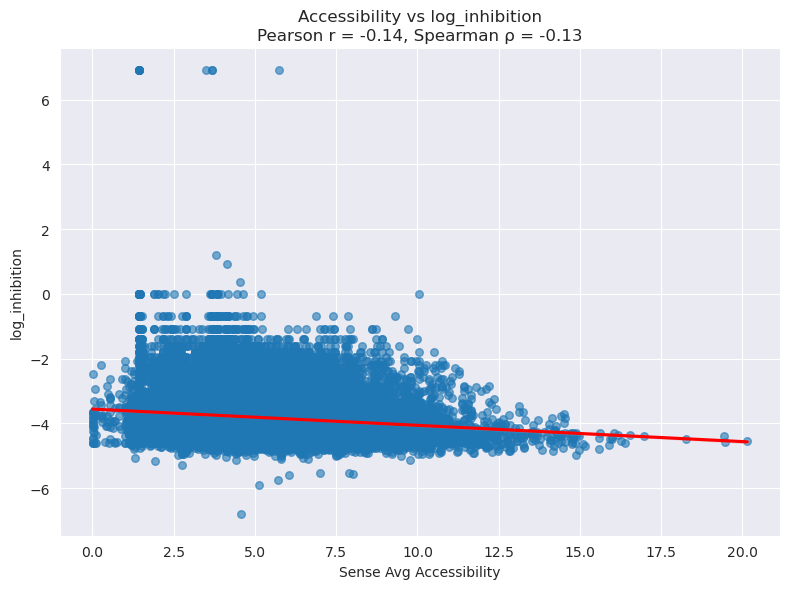

In [28]:

# Compute correlations
pearson_corr, pearson_p = pearsonr(df_corr['sense_avg_accessibility'], df_corr['log_inhibition'])
spearman_corr, spearman_p = spearmanr(df_corr['sense_avg_accessibility'], df_corr['log_inhibition'])

print(f"Pearson correlation: r = {pearson_corr:.4f}, p = {pearson_p:.4e}")
print(f"Spearman correlation: r = {spearman_corr:.4f}, p = {spearman_p:.4e}")

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x='sense_avg_accessibility',
    y='log_inhibition',
    data=df_corr,
    scatter_kws={'s': 30, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title(f'Accessibility vs log_inhibition\nPearson r = {pearson_corr:.2f}, Spearman ρ = {spearman_corr:.2f}')
plt.xlabel('Sense Avg Accessibility')
plt.ylabel('log_inhibition')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_folder}/correlation_plot.png", dpi=300)
plt.show()


In [29]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts', 'features')))

from feature_extraction import save_feature

In [30]:
save_feature(df_all, 'sense_avg_accessibility')

In [31]:
# Keep only the relevant columns
df_to_save = df_all[['index', 'sense_avg_accessibility', 'log_inhibition']].copy()

# Save to CSV
df_to_save.to_csv('average_RNAaccess_win70_seed_13_flank120.csv', index=False)

# Optional: Print confirmation
print("Saved CSV with selected columns to 'average_RNAaccess_win70_seed_13_flank120.csv'")


Saved CSV with selected columns to 'average_RNAaccess_win70_seed_13_flank120.csv'


Remember to delete in the end the partial batches and the "all_data_with_accessibility" file